In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [107]:
def set_seed():
    np.random.seed(20250301)

In [2]:
def simulate_GBM(T,n_steps,X0,sigma):
    """
    Generate Efficient Price Using GBM (BS)
    T: Time Horizon
    n_steps: Number of time steps
    X0: Initial price
    sigma: Volatility
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    dW = np.random.normal(0, np.sqrt(dt), n_steps)
    log_X = np.log(X0) - 0.5 * sigma**2 * t + sigma * np.cumsum(dW)
    X = np.exp(log_X)

    return t, X

In [105]:
def simulate_observed_price(T,n_steps, X0,sigma,alpha,eta):
    t, X = simulate_GBM(T,n_steps,X0,sigma)
    # Generate Traded/Observed Price P
    P = np.zeros_like(X)
    # The first observation price
    P[0] = np.round(X[0] / alpha) * alpha 
    change_indices = [0] 

    for i in range(1, n_steps):
        #discuss in two parts:
        #1. go up: ompute mid price (middle of two nearest ticks)
        if X[i]>=P[i-1]:
            k = np.round(X[i] / alpha)
            mid_price = (k - 0.5) * alpha# Mid price between two adjacent ticks
            # Compute uncertainty zone boundaries based on mid price
            lower = mid_price - alpha * eta
            upper = mid_price + alpha * eta
            if X[i] < lower or X[i] > upper:
                P[i] = np.round(X[i] / alpha) * alpha  # to nearest tick
                change_indices.append(i)  # Mark price change
            else:
                P[i] = P[i-1]  # Price remains unchanged
        else:#go down
            k = np.round(X[i] / alpha)
            mid_price = (k + 0.5) * alpha# Mid price between two adjacent ticks
            # Compute uncertainty zone boundaries based on mid price
            lower = mid_price - alpha * eta
            upper = mid_price + alpha * eta
            if X[i] < lower or X[i] > upper:
                P[i] = np.round(X[i] / alpha) * alpha  # to nearest tick
                change_indices.append(i)  # Mark price change
            else:
                P[i] = P[i-1]  # Price remains unchanged
        '''
        print("x")
        print(X[i])
        print("p")
        print(P[i])
        print("upper")
        print(upper)
        '''
    return t, X, P, change_indices

In [104]:
def simulate_observed_price1(T,n_steps, X0,sigma,alpha,eta):#发现错误
    t, X = simulate_GBM(T,n_steps,X0,sigma)
    # Generate Traded/Observed Price P
    P = np.zeros_like(X)
    # The first observation price
    P[0] = np.round(X[0] / alpha) * alpha 
    change_indices = [0] 

    for i in range(1, n_steps):
        # Compute mid price (middle of two nearest ticks)
        k = np.round(X[i] / alpha)
        mid_price = (k + 0.5) * alpha  # Mid price between two adjacent ticks
        # Compute uncertainty zone boundaries based on mid price
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta

        if X[i] < lower or X[i] > upper:
            print("into")
            P[i] = np.round(X[i] / alpha) * alpha  # to nearest tick
            change_indices.append(i)  # Mark price change
        else:
            P[i] = P[i-1]  # Price remains unchanged
        print("x")
        print(X[i])
        print("p")
        print(P[i])
        print("upper")
        print(upper)
    change_indices.append(n_steps - 1)
    return t, X, P, change_indices

In [103]:
def plot_uncertainty_zone_matplotlib(T,n_steps, X0,alpha, eta,sigma):
    set_seed()
    t, X, P, change_indices = simulate_observed_price(T,n_steps,X0,sigma,alpha,eta)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=0.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(n_steps):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=0.5)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]
        #mid_price_at_start = mid_prices[start]
        #lower_at_start = mid_price_at_start - alpha * (eta)
        #upper_at_start = mid_price_at_start + alpha * (eta)

        #shaded_lower[start:end] = lower_at_start
        #shaded_upper[start:end] = upper_at_start + alpha

    # Fill shaded area **evenly**
    #ax.fill_between(t, shaded_lower, shaded_upper, color="gray", alpha=0.2)
        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        # 填充矩形区域（只填充当前 step）
        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)

    # Show plot
    plt.show()

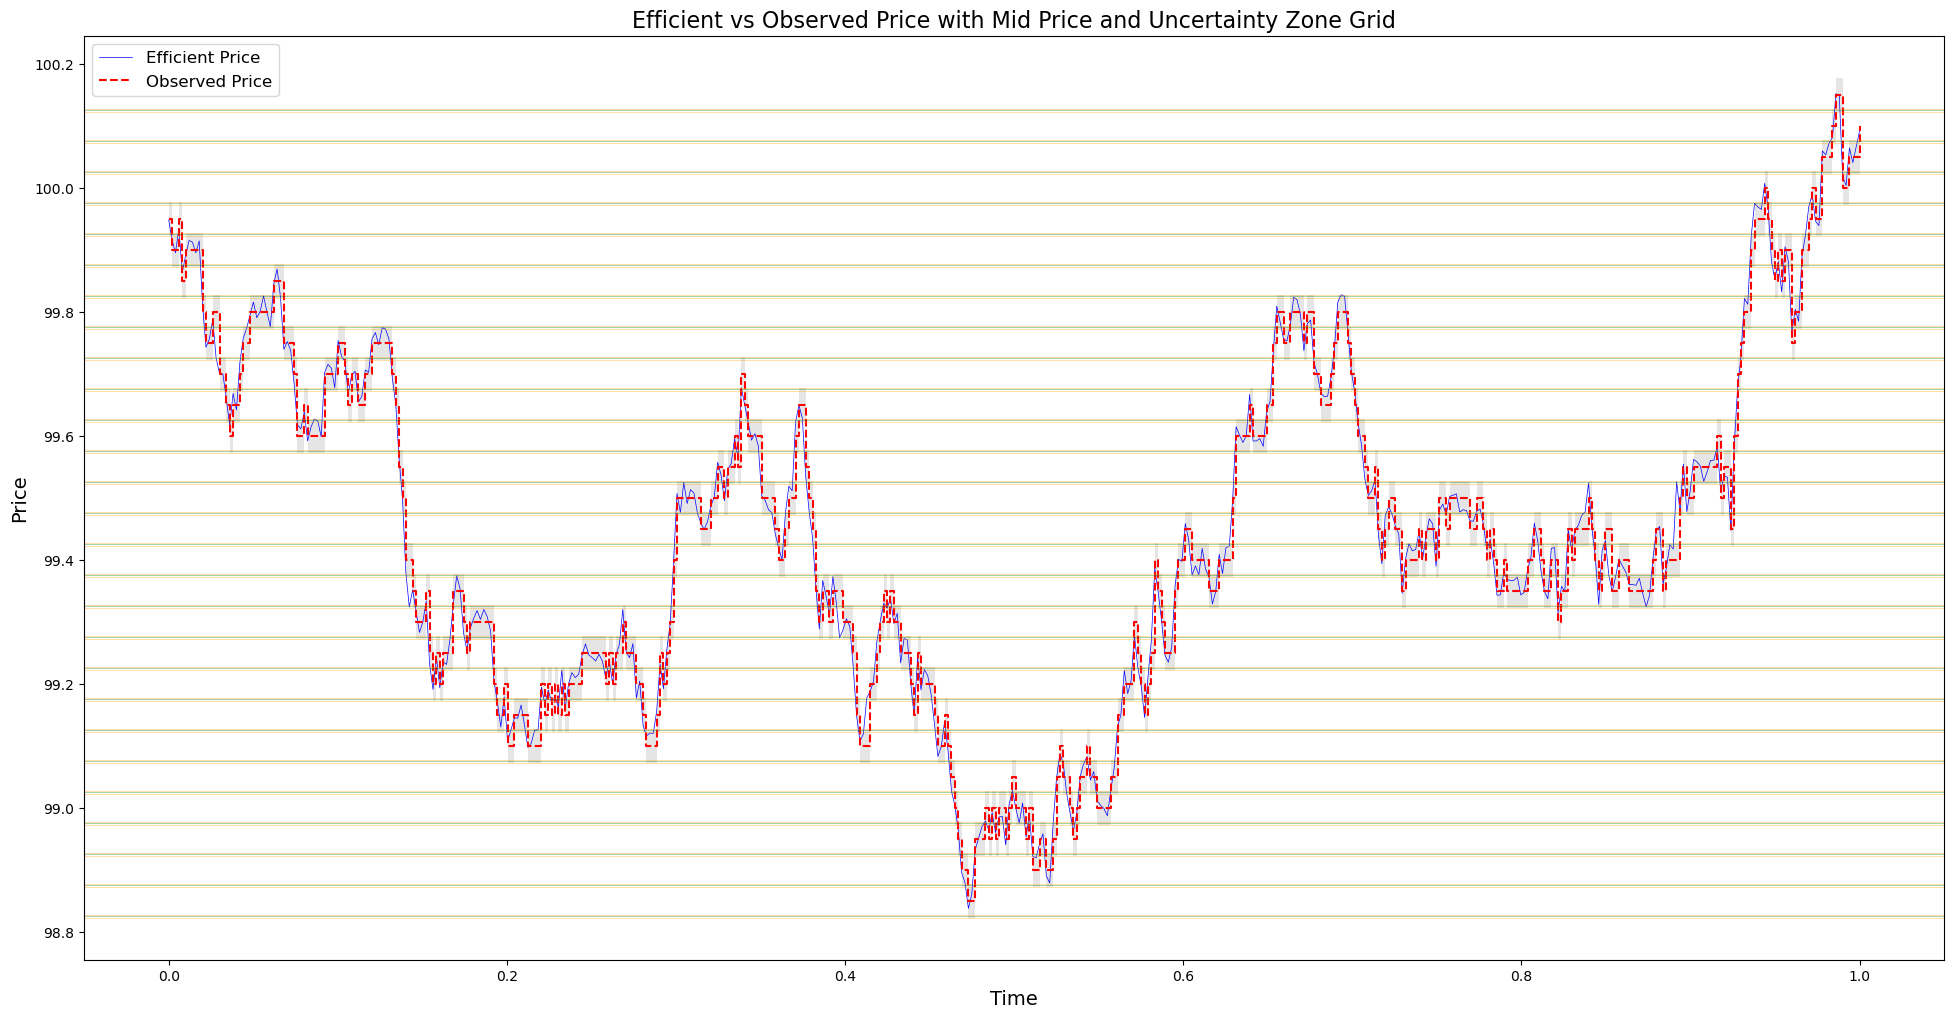

In [115]:
alpha = 0.05      # Tick size
eta = 0.05        # Uncertainty zone width
T = 1.0          # Time horizon
sigma = 0.01      # Volatility, sigma=0.01  5/np.sqrt(252)
X0 = 100.0       # Initial price
n_steps = 500   # Number of time steps
K = 100 # Strike
number_of_paths = 1000 # For Monto Carlo

plot_uncertainty_zone_matplotlib(T,n_steps,X0,alpha,eta,sigma)

In [86]:
def black_scholes_call(S, K, T, r, sigma):
    """
    Computes the BS price and delta of a European call option.
    """
    if sigma < 0 or T < 0:
        raise ValueError("sigma and T must be greater than zero")
    d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)  
    #print(sigma*np.sqrt(T))
    return call_price, delta

In [76]:
def get_optimal_tau(X, alpha, eta):
    tau = [0]
    l = alpha**(-0.5)
    current_zone = (X[0] // alpha) * alpha
    threshold = alpha * (l - 0.5 + eta)
    
    for i in range(1, len(X)):
        upper = current_zone + threshold
        lower = current_zone - threshold
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha
    return tau

In [77]:
def calculate_hedging_error(t, X, P, tau, K, sigma):
    T = t[-1]
    portfolio = np.zeros(len(tau))
    positions = np.zeros(len(tau))
    
    portfolio[0], positions[0] = black_scholes_call(X[tau[0]], K, T - t[tau[0]],0,sigma)
    
    for j in range(1, len(tau)):
        dt = t[tau[j]] - t[tau[j-1]]
        price_change = P[tau[j]] - P[tau[j-1]]
        portfolio[j] = portfolio[j-1] + positions[j-1] * price_change
        remaining_T = T - t[tau[j]]
        _, positions[j] = black_scholes_call(X[tau[j]], K, remaining_T,0,sigma)
    
    final_payoff = max(X[-1] - K, 0)
    return final_payoff - portfolio[-1]

In [116]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

In [90]:
def generate_observed_prices(X, tau, alpha):
    """基于退出时间生成观测价格"""
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.floor(X[i] / alpha) * alpha
        P[i] = current_p if current_p is not None else X[0]
    return P

In [117]:
from tqdm import tqdm
for i in tqdm(range(number_of_paths), desc="Processing Paths"):
        t, X = simulate_GBM(T, n_steps, X0, sigma)
        _, _, P_fixed, tau_fixed = simulate_observed_price(T, n_steps, X0, sigma, alpha, eta)
        tau_optimal = get_optimal_tau(X, alpha, eta)
        #print(tau_optimal)
        #print(tau_optimal)
        P_optimal = generate_observed_prices(X, tau_optimal, alpha)
        
        error_1[i] = calculate_hedging_error(t, X, X, tau_fixed, K, sigma)
        error_2[i] = calculate_hedging_error(t, X, P_fixed, tau_fixed, K, sigma)
        error_3[i] = calculate_hedging_error(t, X, P_optimal, tau_optimal, K, sigma)

Processing Paths:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\10317\AppData\Local\Temp\ipykernel_82560\1116294124.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S)-np.log(K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
Processing Paths: 100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


In [118]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

-0.0007011003308538536
0.0018466084030412198
0.001115274666080977
0.018007447184520752
0.8282033062415847
0.08158556961931125


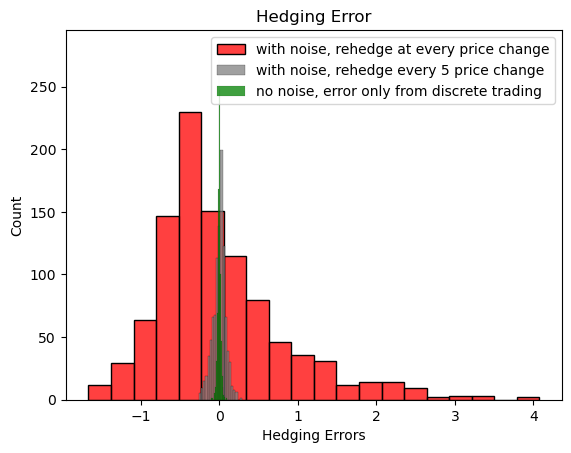

In [119]:
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
sns.histplot(error_3, label = f"with noise, rehedge every 5 price change", bins = 20, color='grey')
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 20, color = 'green')

plt.xlabel("Hedging Errors")
plt.title("Hedging Error")
plt.legend()